# The Lasso

## StatML: Lecture 5

### Prof. James Sharpnack

- Some content and images are from "The Elements of Statistical Learning" by Hastie, Tibshirani, Friedman
- Reading ESL Chapter 3

### Recall Convex Optimization

**Def** A function $f : \mathbb R^p \to \mathbb R$ is convex if for any $0 \le \alpha \le 1$, $x_0, x_1 \in \mathbb R^p$,
$$
f(\alpha x_0 + (1 - \alpha) x_1) \le \alpha f(x_0) + (1 - \alpha) f(x_1).
$$

> For convex functions, local minima are global minima

Recall **1st Order Condition**. If f is differentiable then it is convex if 
$$
f(x) \ge f(x_0) + \nabla f(x_0)^\top (x - x_0), \forall x,x_0
$$
and when $\nabla f(x_0) = 0$ then 
$$
f(x) \ge f(x_0), \forall x
$$
so any fixed point of gradient descent is a global min (for convex, differentiable f)

### Subdifferential

**Def.** $g(x_0) \in \mathbb R^p$ is a *subgradient* of $f$ at $x_0$ if  
$$
f(x) \ge f(x_0) + g(x_0)^\top (x - x_0), \forall x.
$$
The set of all subgradients at $x_0$ is call the *subdifferential*, denoted $\partial f(x_0)$.

> For any global optima, $0 \in \partial f(x_0)$.

### Wavelet denoising

Soft thresholding is commonly used for orthonormal bases.  
- Suppose that we have a vector $y_1,\ldots, y_T$ (like a time series).
- And we want to reconstruct $y$ with $W \beta$ where $\beta$ has a small sum of absolute values $\sum_i |\beta_i|$ 
- $W$ is $T \times T$ and $W W^\top = W^\top W = I$ (orthonormal full rank design)

Want to minimize 
$$
\frac 12 \sum_{i=1}^T (y - W \beta)_i^2 + \lambda \sum_{i=1}^T |\beta_i|.
$$

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
## Explore Turkish stock exchange dataset

tse = pd.read_excel('../../data/data_akbilgic.xlsx',skiprows=1)

tse = tse.rename(columns={'ISE':'TLISE','ISE.1':'USDISE'})

In [3]:
def const_wave(T,a,b):
    wave = np.zeros(T)
    s1 = (b-a) // 2
    s2 = (b-a) - s1
    norm_C = (s1*s2 / (s1+s2))**0.5
    wave[a:a+s1] = norm_C / s1
    wave[a+s1:b] = -norm_C / s2
    return wave

In [4]:
def _const_wave_basis(T,a,b):
    if b-a < 2:
        return []
    wave_basis = []
    wave_basis.append(const_wave(T,a,b))
    mid_pt = a + (b-a)//2
    wave_basis += _const_wave_basis(T,a,mid_pt)
    wave_basis += _const_wave_basis(T,mid_pt,b)
    return wave_basis

In [5]:
def const_wave_basis(T,a,b):
    father = np.ones(T) / T**0.5
    return [father] + _const_wave_basis(T,a,b)

In [6]:
# Construct discrete Haar wavelet basis
T,p = tse.shape
wave_basis = const_wave_basis(T,0,T)
W = np.array(wave_basis).T

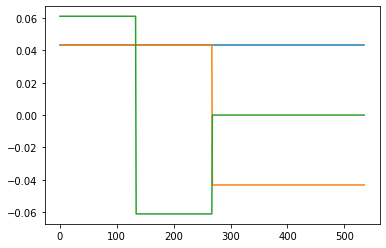

In [7]:
_ = plt.plot(W[:,:3])

In [8]:
def soft(y,lamb):
    pos_part = (y - lamb) * (y > lamb)
    neg_part = (y + lamb) * (y < -lamb)
    return pos_part + neg_part

In [9]:
## Volatility seems most interesting
## will construct local measure of volatility
## remove rolling window estimate (local centering)
## square the residuals

tse = tse.set_index('date')
tse_trem = tse - tse.rolling("7D").mean()
tse_vol = tse_trem**2.

## Make wavelet transformation and soft threshold

tse_wave = W.T @ tse_vol.values
lamb = .001
tse_soft = soft(tse_wave,lamb)
tse_rec = W @ tse_soft
tse_den = tse_vol.copy()
tse_den.iloc[:,:] = tse_rec

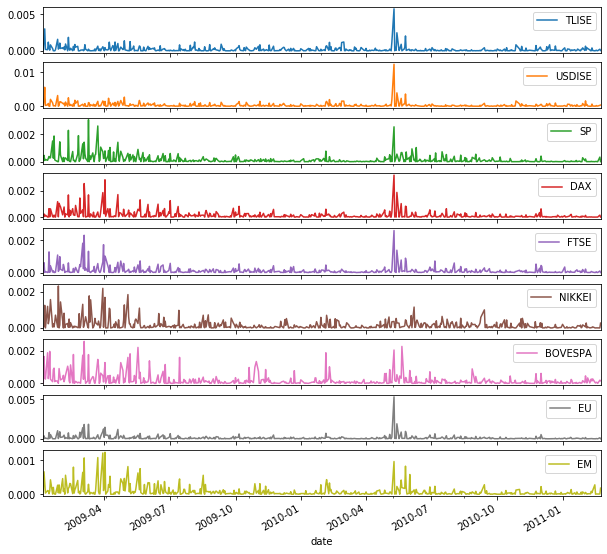

In [10]:
_ = tse_vol.plot(subplots=True,figsize=(10,10))

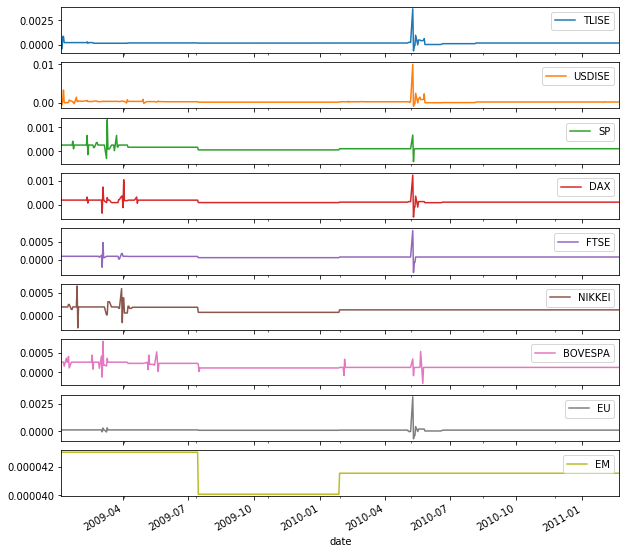

In [11]:
_ = tse_den.plot(subplots=True,figsize=(10,10))

### Wavelet reconstruction

Can reconstruct the sequence by
$$
\hat y = W \hat \beta.
$$
The objective is likelihood term + L1 penalty term,
$$
\frac 12 \sum_{i=1}^T (y - W \beta)_i^2 + \lambda \sum_{i=1}^T |\beta_i|.
$$
> The L1 penalty "forces" some $\beta_i = 0$, inducing sparsity

[  0   2  48  63 344 345]


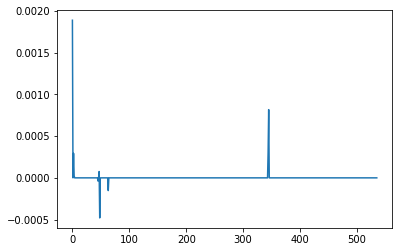

In [12]:
plt.plot(tse_soft[:,4])
high_idx = np.where(np.abs(tse_soft[:,4]) > .0001)[0]
print(high_idx)

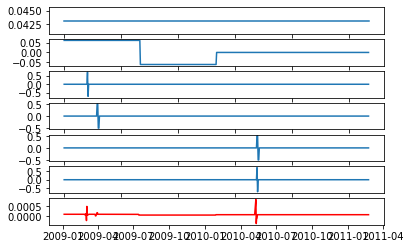

In [13]:
fig, axs = plt.subplots(len(high_idx) + 1,1)
for i, idx in enumerate(high_idx):
    axs[i].plot(W[:,idx])
plt.plot(tse_den['FTSE'],c='r')

### Non-orthogonal design

The objective is likelihood term + L1 penalty term,
$$
\frac 12 \sum_{i=1}^T (y - X \beta)_i^2 + \lambda \sum_{i=1}^T |\beta_i|.
$$
does not have closed form for $X$ that is non-orthogonal. This is called Lasso.

- it is convex
- it is non-smooth (recall $|x|$)
- has tuning parameter $\lambda$

Compare to best subset selection (NP-hard):
$$
\min \frac 12 \sum_{i=1}^T (y - X \beta)_i^2.
$$
for
$$
\| \beta \|_0 = |{\rm supp}(\beta)| < s.
$$

### Image of Lasso solution

<img src="lasso_soln.PNG" width=100%>

### Solving the Lasso

The lasso can be written in *regularized form*,
$$
\min \frac 12 \sum_{i=1}^T (y - X \beta)_i^2 + \lambda \sum_{i=1}^T |\beta_i|,
$$
or in *constrained form*,
$$
\min \frac 12 \sum_{i=1}^T (y - X \beta)_i^2, \quad \textrm{s.t.} \sum_{i=1}^T |\beta_i| \le C,
$$

- For every $\lambda$ there is a $C$ such that the regularized form and constrained form have the same argmin
- This correspondence is data dependent

### Exercise 5.1. Solving the Lasso

A quadratic programing (QP) is any convex optimization of the form 
$$
\min \beta^\top Q \beta + \beta^\top a \quad \textrm{ s.t. } A\beta \le c
$$
where $Q$ is positive semi-definite.

Show that the lasso in constrained form is a QP. (Hint: write $\beta = \beta_+ - \beta_-$ where $\beta_{+,j} = \beta_{j} 1\{ \beta_j > 0\}$ and $\beta_{-,j} = - \beta_{j} 1\{ \beta_j < 0\}$). 

**Solution to 5.1**

The objective is certainly quadratic...
$$
\frac 12 \sum_{i=1}^T (y - X \beta)_i^2 = \frac 12 \beta^\top (X^\top X) \beta - \beta^\top (X^\top y) + C
$$
and we know that $X^\top X$ is PSD because $a^\top X^\top X a = \| X a\|^2 \ge 0$.

What about $\| \beta \|_1$?

![](lasso_QP.PNG)

### Solving the lasso

For a single $\lambda$ in regularized form (or $C$ in constrained form) can solve the lasso with many specialized methods
- quadratic program solver
- proximal gradient
- alternating direction method of multipliers

but $\lambda$ is a tuning parameter.  Options
1. Construct a grid of $\lambda$ and solve each lasso
2. Solve for all $\lambda$ values - path algorithm

### Active sets and why lasso works better

- Let $\hat \beta_\lambda$ be the $\hat \beta$ at tuning parameter $\lambda$.
- Define $\mathcal A_\lambda = {\rm supp}(\hat \beta_\lambda)$ the non-zero elements of $\hat \beta_\lambda$.
 1. For large $\lambda \rightarrow \infty$, $|\mathcal A_\lambda| = 0$
 2. For small $\lambda = 0$, $|\mathcal A_\lambda| = p$ (when OLS solution has full support)
 
Forward greedy selection only adds elements to the active set, does not remove elements.

Note that the intercept is ignored in the penalty term.

### Exercise 5.2.1
Verify 1 and 2 above.

![](active.PNG)

### Lasso Path

This is idealized and is not the actual algorithm.

1. Start at $\lambda = +\infty, \hat \beta = 0$.
2. Decrease $\lambda$ until $\hat \beta_{j_1} \ne 0$, $\mathcal A \gets \{j_1\}$. (Hitting event)
3. Continue decreasing $\lambda$ updating $\mathcal A$ with hitting and leaving events


- $x_{j_1}$ is the predictor variable most correlated with $y$
- Hitting events are when element is added to $\mathcal A$
- Leaving events are when element is removed from $\mathcal A$
- $\hat \beta_{\lambda,j}$ is piecewise linear, continuous, as a function of $\lambda$
- knots are at "hitting" and "leaving" events

![](lasso_path.PNG)
from sklearn.org

### Least Angle Regression (LAR)

1. Standardize predictors and start with residual $r = y - \bar y$, $\hat \beta = 0$
2. Find $x_j$ (also Standardized) most correlated with $r$
3. Move $\beta_j$ in the direction of $x_j^\top r$ until the residual is more correlated with another $x_k$
4. Move $\beta_j,\beta_k$ in the direction of their joint OLS coefficients of $r$ on $(x_j,x_k)$ until some other competitor $x_l$ has as much correlation with the current residual
5. Continue until all predictors have been entered.

### Exercise 5.2.2 
How do we know that LAR does not give us the Lasso solution?

### Lasso modification

4.5 If a non-zero coefficient drops to 0 then remove it from the active set and recompute the restricted OLS.

![](lars_lasso.png)
from ESL

In [14]:
# %load ../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing, model_selection, linear_model

%matplotlib inline

In [17]:
## Simulate a dataset for lasso

n=100
p=1000
X = np.random.randn(n,p)
X = preprocessing.scale(X)

In [18]:
## Subselect true active set

sprob = 0.02
Sbool = np.random.rand(p) < sprob
s = np.sum(Sbool)
print("Number of non-zero's: {}".format(s))

Number of non-zero's: 17


In [19]:
## Construct beta and y

mu = 100.
beta = np.zeros(p)
beta[Sbool] = mu * np.random.randn(s)

eps = np.random.randn(n)
y = X.dot(beta) + eps

### Exercise 5.3

- Run the lasso using `linear_model.lars_path` with the lasso modification (see docstring with ?linear_model.lars_path) 
- Plot the lasso coefficients that are learned as a function of lambda.  You should have a plot with the x-axis being lambda and the y-axis being the coefficient value, with $p=1000$ lines plotted.  Highlight the $s$ coefficients that are truly non-zero by plotting them in red.

(100,) (100, 1000) (1000,)
n_iter =  161
lambda's size= (162,)
number of active variables= 99
size of the coefficients along the path= (1000, 162)


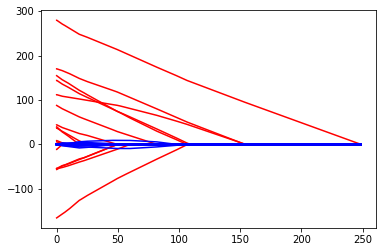

In [67]:
## My answer to exercise 5.3

print(y.shape , X.shape, beta.shape)

# create list of non zero predictors
S = [i for i, x in enumerate(Sbool) if x]
# S = np.where(Sbool)[0]

[lambdas, active, coefs, n_iter]=linear_model.lars_path(X=X, y=y, method= 'lasso',verbose=0, return_n_iter=True)

print("n_iter = " ,n_iter)
print("lambda's size=" , lambdas.shape)
print ("number of active variables=", len(active))
print("size of the coefficients along the path=",coefs.shape)

_=[plt.plot(lambdas,coefs[i,:],'r') for i in range(0,p) if i in S]
_=[plt.plot(lambdas,coefs[i,:],'b') for i in range(0,p) if i not in S]

In [20]:
?linear_model.lars_path

Signature:
linear_model.lars_path(
    X,
    y,
    Xy=None,
    Gram=None,
    max_iter=500,
    alpha_min=0,
    method='lar',
    copy_X=True,
    eps=2.220446049250313e-16,
    copy_Gram=True,
    verbose=0,
    return_path=True,
    return_n_iter=False,
    positive=False,
)
Docstring:
Compute Least Angle Regression or Lasso path using LARS algorithm [1]

The optimization objective for the case method='lasso' is::

(1 / (2 * n_samples)) * ||y - Xw||^2_2 + alpha * ||w||_1

in the case of method='lars', the objective function is only known in
the form of an implicit equation (see discussion in [1])

Read more in the :ref:`User Guide <least_angle_regression>`.

Parameters
----------
X : None or array, shape (n_samples, n_features)
    Input data. Note that if X is None then the Gram matrix must be
    specified, i.e., cannot be None or False.

    .. deprecated:: 0.21

       The use of ``X`` is ``None`` in combination with ``Gram`` is not
       ``None`` will be removed in v0.23. U

In [36]:
## Answer to exercise 5.3
## Run lars with lasso mod, find active set

larper = linear_model.lars_path(X,y,method="lasso")
S = set(np.where(Sbool)[0])

def plot_it():
    for j in S:
        _ = plt.plot(larper[0],larper[2][j,:],'r')
    for j in set(range(p)) - S:
        _ = plt.plot(larper[0],larper[2][j,:],'k',linewidth=.75)
    _ = plt.title('Lasso path for simulated data')
    _ = plt.xlabel('lambda')
    _ = plt.ylabel('Coef')

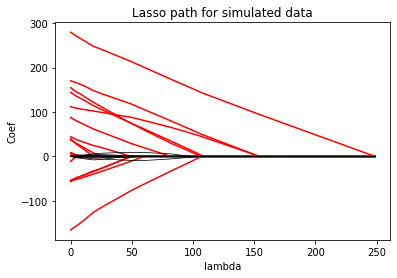

In [37]:
plot_it()

In [69]:
## Modified from the github repo: https://github.com/JWarmenhoven/ISLR-python 
## which is based on the book by James et al. Intro to Statistical Learning.
## Hitters Dataset


df = pd.read_csv('../../data/Hitters.csv', index_col=0).dropna()
df.index.name = 'Player'
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, -Alan Ashby to -Willie Wilson
Data columns (total 20 columns):
AtBat        263 non-null int64
Hits         263 non-null int64
HmRun        263 non-null int64
Runs         263 non-null int64
RBI          263 non-null int64
Walks        263 non-null int64
Years        263 non-null int64
CAtBat       263 non-null int64
CHits        263 non-null int64
CHmRun       263 non-null int64
CRuns        263 non-null int64
CRBI         263 non-null int64
CWalks       263 non-null int64
League       263 non-null object
Division     263 non-null object
PutOuts      263 non-null int64
Assists      263 non-null int64
Errors       263 non-null int64
Salary       263 non-null float64
NewLeague    263 non-null object
dtypes: float64(1), int64(16), object(3)
memory usage: 43.1+ KB


In [70]:
df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
Player,,,,,,,,,,,,,,,,,,,,
-Alan Ashby,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
-Alvin Davis,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
-Andre Dawson,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
-Andres Galarraga,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
-Alfredo Griffin,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A


In [72]:
# convert the categorical variables to numerical with pandas
dummies = pd.get_dummies(df[['League', 'Division', 'NewLeague']])
dummies.info()
print(dummies.head())

<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, -Alan Ashby to -Willie Wilson
Data columns (total 6 columns):
League_A       263 non-null uint8
League_N       263 non-null uint8
Division_E     263 non-null uint8
Division_W     263 non-null uint8
NewLeague_A    263 non-null uint8
NewLeague_N    263 non-null uint8
dtypes: uint8(6)
memory usage: 3.6+ KB
                   League_A  League_N  Division_E  Division_W  NewLeague_A  \
Player                                                                       
-Alan Ashby               0         1           0           1            0   
-Alvin Davis              1         0           0           1            1   
-Andre Dawson             0         1           1           0            0   
-Andres Galarraga         0         1           1           0            0   
-Alfredo Griffin          1         0           0           1            1   

                   NewLeague_N  
Player                          
-Alan Ashby             

In [75]:
y = df.Salary

# Drop the column with the independent variable (Salary), and columns for which we created dummy variables
X_ = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')
# Define the feature set X.
X = pd.concat([X_, dummies[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, -Alan Ashby to -Willie Wilson
Data columns (total 19 columns):
AtBat          263 non-null float64
Hits           263 non-null float64
HmRun          263 non-null float64
Runs           263 non-null float64
RBI            263 non-null float64
Walks          263 non-null float64
Years          263 non-null float64
CAtBat         263 non-null float64
CHits          263 non-null float64
CHmRun         263 non-null float64
CRuns          263 non-null float64
CRBI           263 non-null float64
CWalks         263 non-null float64
PutOuts        263 non-null float64
Assists        263 non-null float64
Errors         263 non-null float64
League_N       263 non-null uint8
Division_W     263 non-null uint8
NewLeague_N    263 non-null uint8
dtypes: float64(16), uint8(3)
memory usage: 35.7+ KB


In [32]:
X.head(5)

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,League_N,Division_W,NewLeague_N
Player,,,,,,,,,,,,,,,,,,,
-Alan Ashby,315.0,81.0,7.0,24.0,38.0,39.0,14.0,3449.0,835.0,69.0,321.0,414.0,375.0,632.0,43.0,10.0,1,1,1
-Alvin Davis,479.0,130.0,18.0,66.0,72.0,76.0,3.0,1624.0,457.0,63.0,224.0,266.0,263.0,880.0,82.0,14.0,0,1,0
-Andre Dawson,496.0,141.0,20.0,65.0,78.0,37.0,11.0,5628.0,1575.0,225.0,828.0,838.0,354.0,200.0,11.0,3.0,1,0,1
-Andres Galarraga,321.0,87.0,10.0,39.0,42.0,30.0,2.0,396.0,101.0,12.0,48.0,46.0,33.0,805.0,40.0,4.0,1,0,1
-Alfredo Griffin,594.0,169.0,4.0,74.0,51.0,35.0,11.0,4408.0,1133.0,19.0,501.0,336.0,194.0,282.0,421.0,25.0,0,1,0


### Exercise 5.4

You should cross-validate to select the lambda just like any other tuning parameter.  Sklearn gives you the option of using their fast cross-validation script via `linear_model.LassoCV`, see the documentation.  You can create a leave-one-out cross validator with `model_selection.LeaveOneOut` then pass this to `LassoCV` with the `cv` argument.  Do this, and see what the returned fit and selected lambda are.

This is a subset selection example. We don't care about the prediction.

In [84]:
## My answer to 5.4

LOO = model_selection.LeaveOneOut()
LASSO = linear_model.LassoCV(cv = LOO)
LASSO.fit(X,y)

print("Lambda is =",LASSO.alpha_)
print("betas are =",LASSO.coef_)

Lambda is = 540.6556677332911
betas are = [-0.          1.49586273  0.          0.          0.          1.13979587
 -0.         -0.33734233  0.82306877  0.          0.79947238  0.65458696
 -0.03331169  0.27575248  0.13166923 -0.          0.         -0.
  0.        ]


In [79]:
## Answer to 5.4
## Fit the lasso and cross-validate, increased max_iter to achieve convergence
loo = model_selection.LeaveOneOut()
looiter = loo.split(X)
hitlasso = linear_model.LassoCV(cv=looiter,max_iter=2000) 
hitlasso.fit(X,y)

LassoCV(alphas=None, copy_X=True,
        cv=<generator object BaseCrossValidator.split at 0x1a32e8fcd0>,
        eps=0.001, fit_intercept=True, max_iter=2000, n_alphas=100, n_jobs=None,
        normalize=False, positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

In [80]:
print("The selected lambda value is {:.2f}".format(hitlasso.alpha_))

The selected lambda value is 540.66


In [81]:
hitlasso.coef_

array([-0.        ,  1.49581634,  0.        ,  0.        ,  0.        ,
        1.13968178, -0.        , -0.33741746,  0.82331967,  0.        ,
        0.79940936,  0.65462067, -0.03322761,  0.27574744,  0.13169212,
       -0.        ,  0.        , -0.        ,  0.        ])

We can also compare this to the selected model from forward stagewise regression:

```
[-0.21830515,  0.38154135,  0.        ,  0.        ,  0.        ,
        0.16139123,  0.        ,  0.        ,  0.        ,  0.        ,
        0.09994524,  0.56696569, -0.16872682,  0.16924078,  0.        ,
        0.        ,  0.        , -0.19429699,  0.        ]
```

This is not exactly the same model with differences in the inclusion or exclusion of AtBat, HmRun, Runs, RBI, Years, CHmRun, Errors, League_N, Division_W, NewLeague_N

In [82]:
bforw = [-0.21830515,  0.38154135,  0.        ,  0.        ,  0.        ,
        0.16139123,  0.        ,  0.        ,  0.        ,  0.        ,
        0.09994524,  0.56696569, -0.16872682,  0.16924078,  0.        ,
        0.        ,  0.        , -0.19429699,  0.        ]

In [83]:
print(", ".join(X.columns[(hitlasso.coef_ != 0.) != (bforw != 0.)]))

AtBat, HmRun, Runs, RBI, Years, CHmRun, Errors, League_N, Division_W, NewLeague_N
